In [45]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path


In [46]:
# Load lorenz data and check dimensions
data_filename = Path('../data/lorenz_training.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")
lorenz_data_training = np.load(data_filename)
# Check the shape of the data
print(f"Data shape: {lorenz_data_training.shape}")
if lorenz_data_training.ndim != 2:
    raise ValueError(f"Expected 2D array, got {lorenz_data_training.ndim}D array.")

Data shape: (5001, 3)


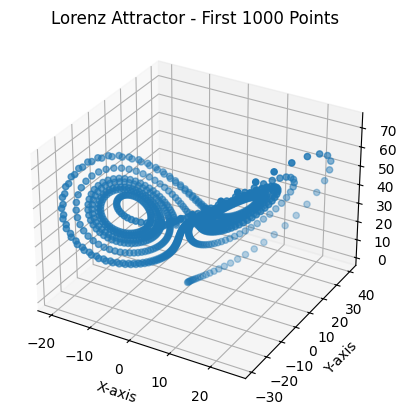

In [47]:
# lorenz data exploration
# plot the first 1000 points, 3 dimensional plot
import matplotlib.pyplot as plt
# Scatter plot of the first 1000 points in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_training[:1000, 0], lorenz_data_training[:1000, 1], lorenz_data_training[:1000, 2])
plt.title('Lorenz Attractor - First 1000 Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


Validation data shape: (5000, 3)


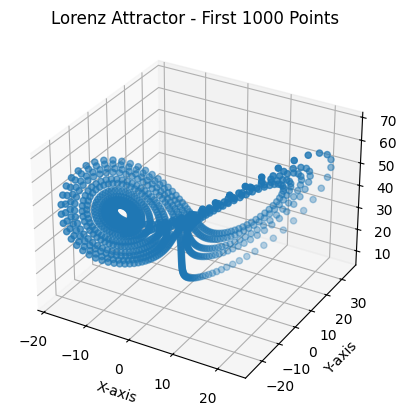

In [48]:
# Load vallidation data and check dimensions
data_filename = Path('../data/lorenz_truth.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")
lorenz_data_validation = np.load(data_filename)
# Check the shape of the data
print(f"Validation data shape: {lorenz_data_validation.shape}")
if lorenz_data_validation.ndim != 2:
    raise ValueError(f"Expected 2D array, got {lorenz_data_validation.ndim}D array.")
# lorenz data exploration
# plot the first 1000 points, 3 dimensional plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_validation[:1000, 0], lorenz_data_validation[:1000, 1], lorenz_data_validation[:1000, 2])
plt.title('Lorenz Attractor - First 1000 Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [49]:
# Simple MLP model that takes in 3 inputs and outputs 3 values
class MLP(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
# Torch dataloader
class LorenzDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_steps=1, output_steps=1, flatten=False):
        self.data = data
        self.output_steps = output_steps
        self.input_steps = input_steps
        self.flatten = flatten
        if data.ndim != 2:
            raise ValueError(f"Expected 2D array, got {data.ndim}D array.")
        if data.shape[1] != 3:
            raise ValueError(f"Expected 3 features, got {data.shape[1]} features.")
        if input_steps + output_steps > len(data):
            raise ValueError("Input and output steps exceed data length.")

    def __len__(self):
        return len(self.data) - self.output_steps - self.input_steps +1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_steps]
        if self.flatten:
            x = x.flatten()
        y = self.data[idx + self.input_steps:idx + self.input_steps + self.output_steps]
        if self.flatten:
            y = y.flatten()
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [51]:
# Test dataset and dataloader
lorenz_dataset = LorenzDataset(lorenz_data_training, input_steps=5,output_steps=1, flatten=True)
lorenz_dataloader = torch.utils.data.DataLoader(lorenz_dataset, batch_size=16, shuffle=True)
print(f"Number of batches: {len(lorenz_dataloader)}")
# Sample a few batches
for i, (x, y) in enumerate(lorenz_dataloader):
    print(f"Batch {i}:")
    print(f"x: {x.shape}, y: {y.shape}")
    if i == 2:  # Just show a few batches
        break

Number of batches: 313
Batch 0:
x: torch.Size([16, 15]), y: torch.Size([16, 3])
Batch 1:
x: torch.Size([16, 15]), y: torch.Size([16, 3])
Batch 2:
x: torch.Size([16, 15]), y: torch.Size([16, 3])


In [52]:
input_steps = 5
output_steps = 4
n_features = lorenz_data_training.shape[1]

# Initialize the model
model = MLP(input_dim=input_steps * n_features, output_dim=output_steps * n_features, hidden_dim=128)
# Print model summary
def print_model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")



In [53]:
# Dataloaders
batch_size = 32
training_dataset = LorenzDataset(lorenz_data_training, input_steps=input_steps,output_steps=output_steps, flatten=True)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = LorenzDataset(lorenz_data_validation, input_steps=input_steps,output_steps=output_steps, flatten=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [54]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Training loop using tqdm
num_epochs = 100
num_epochs_validation = 50
from tqdm import tqdm
from tqdm import trange
# Training loop
pbar = trange(num_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()    

    pbar.set_postfix(loss=running_loss / len(training_dataloader))
    # Validation loop
    if epoch % num_epochs_validation == 0:
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for i, (x, y) in enumerate(validation_dataloader):
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                validation_loss += loss.item()
        print(f"Validation loss: {validation_loss / len(validation_dataloader)}")



Training:   1%|          | 1/100 [00:00<00:13,  7.37epoch/s, loss=303]

Validation loss: 50.61012928913801


Training:  52%|█████▏    | 52/100 [00:05<00:04, 10.00epoch/s, loss=0.034] 

Validation loss: 0.035059901273761615


Training: 100%|██████████| 100/100 [00:09<00:00, 10.77epoch/s, loss=0.00768]


In [67]:
# Evaluate the model autoregressively
def evaluate_model_autoregressive(model, data, input_steps=5, output_steps=1):
    model.eval()
    with torch.no_grad():
        # Initialize the input with the first input_steps data points
        x = torch.tensor(data[:input_steps], dtype=torch.float32)

        # print(f"Initial input shape: {x.shape}")
        predictions = []
        predictions.append(x.numpy())
        for _ in range(len(data) - input_steps - output_steps +1):
            y_pred = model(x.flatten().unsqueeze(0))
            # print(f"Predicted shape: {y_pred.shape}")
            # Reshape the prediction to match the output shape
            y_pred = y_pred.reshape(output_steps, 3)
            predictions.append(y_pred.numpy())
            # print(f"Predictions shape: {np.array(predictions[0]).shape}")
            # Update the input with the new prediction
            # Concatenate the new prediction to the input
            x = torch.cat((x, y_pred), dim=0)[:input_steps]
    return np.array(predictions)

In [68]:
print(len(training_dataset[0]), len(training_dataset[0][0]), len(training_dataset[0][1]))
preds = evaluate_model_autoregressive(model, lorenz_data_training, input_steps=input_steps, output_steps=output_steps)
print(f"Predictions shape: {preds.shape}")

2 15 12


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4994,) + inhomogeneous part.